## Analyzing CIA Factbook Data Using SQLite and Python

### Introduction

In this project, we'll work with data from [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/ ), a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like:
- `population` - The population as of 2015.
- `population_growth` - The annual population growth rate, as a percentage.
- `area` - The total land and water area.
[Data source](https://github.com/factbook/factbook.sql/releases)

The purpose of this project is to explore, analyze and visualize data using Python SQLite.

### Overview of the Data

In [1]:
# imports
import sqlite3
import pandas as pd

In [2]:
# create the connection and explore the data
conn = sqlite3.connect("factbook.db")

q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
q1 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(q1, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:
- `name` - The name of the country.
- `area` - The total land and area of the country.
- `population` - The country's population.
- `population_growth` - The country's population growth as a percentage.
- `birth_rate` - The country's birth rate, or the number of births a year per 1000 people.
- `death_rate`- The country's death rate, or the number of deaths a year per 1000 people.
- `area` - The country's total area (both land and water).
- `area_land` - The country's land area in square kilometers.
- `area_water` - The country's water area in square kilometers.

Let's start by calculating some summary statistics and look for any outlier countries.

### Summary Statistics

In [4]:
q2 = '''SELECT MIN(population) min_pop,
               MAX(population) max_pop, 
               MIN(population_growth) min_pop_growth, 
               MAX(population_growth) max_pop_growth
        FROM facts;'''
pd.read_sql_query(q2, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics:
- there is a country with a population of 0.
- there is a country with a population of 7256490011 (or more than 7.2 billion people).

Let's zoom in on just these countries.

### Exploring Outliers

In [5]:
q3 = '''SELECT * FROM facts
        WHERE population == (SELECT MIN(population) FROM facts);'''
pd.read_sql_query(q3, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [6]:
q4 = '''SELECT * FROM facts
        WHERE population == (SELECT MAX(population) FROM facts);'''
pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


It seems like the table contains one row for the whole world, which explains the population of over 7.2 billion. It also seems like the table contains a row for Antarctica, which explains the population of 0. This matches the CIA Factbook [page for Antarctica](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html) :
![Anatarctica_population](img/Antarctica_pop.png)

Let's move on to generating histograms for the rest of the countries, ignoring these 2 rows.

### Histograms

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA63D4F940>,
      dtype=object)

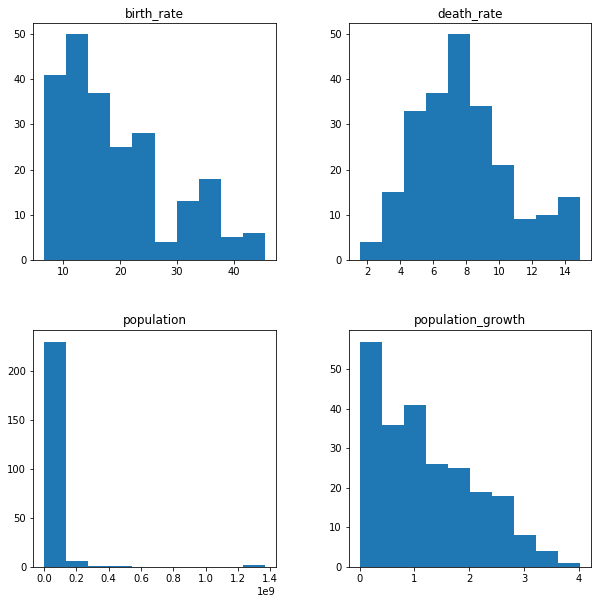

In [7]:
# plot histograms
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

q5 = '''select population, 
                population_growth, 
                birth_rate, 
                death_rate
        from facts
        where population != (select max(population) from facts)
              and population != (select min(population) from facts);
    '''

pd.read_sql_query(q5, conn).hist(ax=ax, grid=False)

From the histograms above we can picture the central tendency of the data. The `date_rate` column has a normal distribution, the mean, median and mode being almost equal. The distribution for `birth_rate`, `population` and `population_growth` is right-skewed, the mean is greater than the mode, which means most of the data falls below the median value of each column.
### Which countries have the highest population density?

In [8]:
q6 = '''
        select name, 
                cast(population as float) / cast(area as float) density
        from facts
        order by 2 desc
       limit 10;'''

pd.read_sql_query(q6, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


We found the population density by calculating the ratio of population to land area and selected the top 10 countries by density. The results are similar to those from [Wikipedia](https://simple.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density).

Let's generate a histogram of population densities.

C:\Users\maria\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


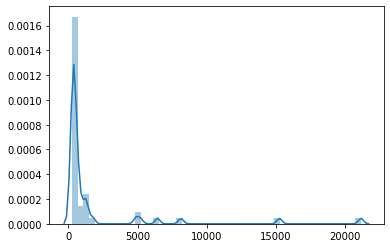

In [9]:
# plot histogram
import seaborn as sns
%matplotlib inline

q7 =  '''select
            cast(population as float) / cast(area as float) density
        from facts
        order by 1 desc
        limit 50;'''

sns.distplot(pd.read_sql_query(q7, conn))

Most of the countries have population density below the mean of densities for the entire data set.

Let's explore the ratios of water to land. Which countries have more water than land?
### Water to Land Ratio

In [10]:
q8 = '''
        select name, 
                cast(area_water as float) * 100 / cast(area as float) water_area_percentage
        from facts
        order by 2 desc
        limit 10;'''

pd.read_sql_query(q8, conn)

,name,water_area_percentage
0,British Indian Ocean Territory,99.889706
1,Virgin Islands,81.884817
2,Puerto Rico,35.682692
3,"Bahamas, The",27.881844
4,Guinea-Bissau,22.159170
5,Malawi,20.596874
6,Netherlands,18.414655
7,Uganda,18.228661
8,Eritrea,14.115646
9,Liberia,13.512737


In [11]:
q9 = '''
        select name, 
                cast(area_water as float) * 100 / cast(area as float) water_area_percentage
        from facts
        where water_area_percentage > 50
        order by 2 desc;'''

pd.read_sql_query(q9, conn)

,name,water_area_percentage
0,British Indian Ocean Territory,99.889706
1,Virgin Islands,81.884817


There are two countries in the world which have more than 50% of water from their territory, respectively the Virgin Islands with 81% of water and British Indian Ocean Territory with 99% of water.